@author ArturoSirvent   
@date 19-02-2024

En este notebook se prueba a hacer cargar unos collocations points solo para la parte de la próstata y no un cubo al rededor.  

In [26]:
#librerias

import torch

import pandas as pd
import numpy as np
import re 
import random
from dataclasses import dataclass
import plotly.express as px

In [21]:
#vamos a hacer una función para cargar todos los datos de una   
@dataclass
class Data:
    folder: str
    load_stage: int
    base_dir:str = "/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
    E: str = None
    #===== not seteables ====
    initialPosition_data_pd: pd.DataFrame =None
    stress_data_pd: pd.DataFrame =None
    displacement_data_pd: pd.DataFrame=None
    restricted_data_pd: pd.DataFrame =None
    force_data_pd: pd.DataFrame =None 
    final_data_pd: pd.DataFrame =None
    collocation_data_np:pd.DataFrame =None
    Pos_min: np.ndarray = None
    Pos_max: np.ndarray = None
    adjancet_matrix: np.ndarray=None
    device : str ="cpu"
    _data_loaded : bool =False
    _is_normaliced: bool = False

    @staticmethod
    def keep_line(line):
        line_split=line.split()
        try:
            int(line_split[0])
            #si no dio error, okey entra
            return True
        except:
            return False

    def load_data(self,load_stage=10,normalize_pos=False):
        # carga las posiciones de los nodos    
        initialPosition_data_path = f"{self.base_dir}/ARTURO_TEST_1/NODES.txt"

        with open(initialPosition_data_path,"r") as f:
            aux_list=f.readlines()

        initialPosition_data=[i for i in aux_list if self.keep_line(i)]
        initialPosition_data=[i.strip("\n") for i in initialPosition_data]
        initialPosition_data=[i.split() for i in initialPosition_data]
        initialPosition_data_np=np.array(initialPosition_data).astype(float)[:,[0,1,2,3]]
        self.initialPosition_data_pd=pd.DataFrame(initialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
        self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
        self.Pos_max=self.initialPosition_data_pd.max().to_numpy()

        #noramlizamos las posiciones 
        if normalize_pos:
            self._is_normaliced=True
            #la normalizacion de hace min max porque queremos escalar los datos no cambiar su distribucion espacial
            self.initialPosition_data_pd=(self.initialPosition_data_pd-self.initialPosition_data_pd.min())/(self.initialPosition_data_pd.max()-self.initialPosition_data_pd.min())
            #ahora han cambiado los valores de las posiciones minima y máxima.
            self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
            self.Pos_max=self.initialPosition_data_pd.max().to_numpy()
        #carga el streess
        if self.E is not None:
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES_E{self.E}.txt"
        else: 
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"

        with open(stress_data_path,"r") as f:
            aux_list=f.readlines()

        stress_data=[i for i in aux_list if self.keep_line(i)]
        stress_data=[i.strip("\n").strip() for i in stress_data]
        patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

        stress_data=[re.findall(patron,i) for i in stress_data]
        stress_data=np.array(stress_data,dtype=float)
        self.stress_data_pd=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")[["SX","SY","SZ","SYZ","SXZ","SXY"]] # lo queremos asi : s11,s22,s33,s23,s13,s12

        # cargar datos de desplazamiento  
        if self.E is not None:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP_E{self.E}.txt"
        else:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP.txt"

        with open(displacement_data_path,"r") as f:
            aux_list=f.readlines()


        displacement_data=[i for i in aux_list if self.keep_line(i)]
        displacement_data=[i.strip("\n").strip() for i in displacement_data]
        patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

        displacement_data=[re.findall(patron,i) for i in displacement_data]
        displacement_data=np.array(displacement_data,dtype=float)
        self.displacement_data_pd=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

        # cargar datos de boundaries en el movimiento
        #cargar los nodos fijos
        with open(f"{self.base_dir}/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
            restricted_data=f.readlines()

        restricted_data=[i for i in restricted_data if self.keep_line(i)]
        restricted_data=[i.strip("\n") for i in restricted_data]
        restricted_data=[i.split() for i in restricted_data]
        restricted_data_np=np.array(restricted_data)[:,[0,1]]
        self.restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
        self.restricted_data_pd=self.restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
        self.restricted_data_pd.index=self.restricted_data_pd.index.astype(int)
        self.restricted_data_pd=self.restricted_data_pd.sort_index()
        self.restricted_data_pd=self.restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

        with open(f"{self.base_dir}/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
            force_data=f.readlines()


        force_data=[i for i in force_data if self.keep_line(i)]
        force_data=[i.strip("\n") for i in force_data]
        force_data=[i.split() for i in force_data]
        force_data_np=np.array(force_data)[:,[0,1,2]]
        self.force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
        self.force_data_pd["Fuerza"]=self.force_data_pd["Fuerza"].astype(float)
        self.force_data_pd=self.force_data_pd.set_index("Node")
        self.force_data_pd.index=self.force_data_pd.index.astype(int)


        #ponemos todos los datos en común usando los nodos como clave   
        self.final_data_pd=self.initialPosition_data_pd.merge(self.stress_data_pd,left_index=True,right_index=True,how="left").merge(self.force_data_pd,left_index=True,right_index=True,how="left").merge(self.displacement_data_pd,left_index=True,right_index=True,how="left").merge(self.restricted_data_pd,left_index=True,right_index=True,how="left")

        self.final_data_pd["Final_X"]=self.final_data_pd["X"]-self.final_data_pd["UX"]
        self.final_data_pd["Final_Y"]=self.final_data_pd["Y"]-self.final_data_pd["UY"]
        self.final_data_pd["Final_Z"]=self.final_data_pd["Z"]-self.final_data_pd["UZ"]
        
        self._data_loaded=True


In [22]:
data=Data(folder="MULTIPLE_E_VALUES",load_stage=10,E="0.032")

In [23]:
data.load_data(10,normalize_pos=True)

In [30]:
data.initialPosition_data_pd

,X,Y,Z
Node,,,
1.0,0.636327,0.550145,0.006695
2.0,0.304908,0.616828,0.005560
3.0,0.804259,0.143333,0.517918
4.0,0.997894,0.500626,0.575784
5.0,0.057977,0.789478,0.569297
...,...,...,...
4147.0,0.662518,0.420325,0.543978
4148.0,0.562243,0.412249,0.432000
4149.0,0.623859,0.443885,0.469318


In [33]:
from scipy.spatial import ConvexHull, Delaunay


In [48]:
envolvente = ConvexHull(data.initialPosition_data_pd)


In [49]:
envolvente.points

array([[0.63632689, 0.55014525, 0.00669462],
       [0.30490841, 0.61682791, 0.00555955],
       [0.80425948, 0.14333307, 0.51791795],
       ...,
       [0.62385907, 0.44388476, 0.46931826],
       [0.61073169, 0.54153674, 0.4333897 ],
       [0.43250144, 0.55201087, 0.34821284]])

In [55]:
envolvente_df = pd.DataFrame(envolvente.points[envolvente.vertices,:], columns=['X', 'Y', 'Z'])
# envolvente_df.loc[envolvente_df["X"]>0.5]=0
# envolvente_df.loc[envolvente_df["Y"]>0.5]=0
px.scatter_3d(envolvente_df, x='X', y='Y', z='Z')



In [61]:
# Generamos puntos aleatorios dentro de un cubo grande
num_puntos_aleatorios = 15000
puntos_aleatorios = np.random.rand(num_puntos_aleatorios, 3) 


In [62]:
delaunay = Delaunay(envolvente.points[envolvente.vertices,:])


In [63]:
indices_dentro = delaunay.find_simplex(puntos_aleatorios) >= 0
puntos_dentro = puntos_aleatorios[indices_dentro]
puntos_dentro.shape

(7527, 3)

In [68]:
collocation_points_df = pd.DataFrame(puntos_dentro, columns=['X', 'Y', 'Z'])
# envolvente_df.loc[envolvente_df["X"]>0.5]=0
# envolvente_df.loc[envolvente_df["Y"]>0.5]=0
px.scatter_3d(envolvente_df, x='X', y='Y', z='Z',color_discrete_sequence=['blue'])
px.scatter_3d(collocation_points_df, x='X', y='Y', z='Z',color_discrete_sequence=['red'])

In [70]:
import plotly.graph_objects as go
import pandas as pd

# Asumiendo que envolvente_df y collocation_points_df son tus DataFrames

envolvente_df_half=envolvente_df[envolvente_df["X"]<0.5]
collocation_points_df_half=collocation_points_df[collocation_points_df["X"]<0.5]
# Creando el primer gráfico (envolvente)
fig = go.Figure(data=[go.Scatter3d(
    x=envolvente_df_half['X'],
    y=envolvente_df_half['Y'],
    z=envolvente_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Puedes ajustar el tamaño del marcador
        color='blue',  # Color de los marcadores para envolvente_df
    )
)])

# Agregando el segundo gráfico (collocation_points) a la figura existente
fig.add_trace(go.Scatter3d(
    x=collocation_points_df_half['X'],
    y=collocation_points_df_half['Y'],
    z=collocation_points_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Ajusta el tamaño del marcador si es necesario
        color='red',  # Color de los marcadores para collocation_points_df
    )
))

# Ajustes adicionales para la figura, como título, tamaño de los ejes, etc.
fig.update_layout(
    title="Visualización 3D combinada",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Mostrando la figura
fig.show()


In [79]:
px.scatter_3d(data.initialPosition_data_pd,x="X",y="Y",z="Z",opacity=0.5)

Creo que sería conveniente tener los puntos un poquitín mas alla que la frontera...

In [ ]:
envolvente = ConvexHull(data.initialPosition_data_pd)

In [71]:
centroide = np.mean(envolvente.points[envolvente.vertices], axis=0)
centroide

array([0.50152191, 0.49579488, 0.52705083])

In [93]:
# Calculando el centroide del envolvente convexo
centroide = np.mean(envolvente.points[envolvente.vertices], axis=0)

# Escalando los puntos del envolvente convexo desde el centroide
factor_de_escala = 1.1 #5% más grande
puntos_vertices_escalados = np.array([centroide + (punto - centroide) * factor_de_escala for punto in envolvente.points[envolvente.vertices]])


In [94]:
envolventes_df = pd.DataFrame(envolvente.points[envolvente.vertices], columns=['X', 'Y', 'Z'])
envolventes_aumentada_df = pd.DataFrame(puntos_vertices_escalados, columns=['X', 'Y', 'Z'])


In [95]:
import plotly.graph_objects as go
import pandas as pd

# Asumiendo que envolvente_df y collocation_points_df son tus DataFrames

envolventes_df_half=envolventes_df[envolventes_df["X"]<0.5]
envolventes_aumentada_df_half=envolventes_aumentada_df[envolventes_aumentada_df["X"]<0.5]
# Creando el primer gráfico (envolvente)
fig = go.Figure(data=[go.Scatter3d(
    x=envolventes_df_half['X'],
    y=envolventes_df_half['Y'],
    z=envolventes_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Puedes ajustar el tamaño del marcador
        color='blue',  # Color de los marcadores para envolvente_df
    )
)])

# Agregando el segundo gráfico (collocation_points) a la figura existente
fig.add_trace(go.Scatter3d(
    x=envolventes_aumentada_df_half['X'],
    y=envolventes_aumentada_df_half['Y'],
    z=envolventes_aumentada_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Ajusta el tamaño del marcador si es necesario
        color='red',  # Color de los marcadores para collocation_points_df
    )
))

# Ajustes adicionales para la figura, como título, tamaño de los ejes, etc.
fig.update_layout(
    title="Visualización 3D combinada",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Mostrando la figura
fig.show()


Y creamos los colocations ligeramente más amplio que la zona ocupada por la próstata.   

In [96]:
# Generamos puntos aleatorios dentro de un cubo grande
num_puntos_aleatorios = 45000
puntos_aleatorios_2 = np.random.rand(num_puntos_aleatorios, 3) 
delaunay_extra = Delaunay(envolventes_aumentada_df)
indices_dentro = delaunay_extra.find_simplex(puntos_aleatorios_2) >= 0
puntos_dentro_2 = puntos_aleatorios_2[indices_dentro]
puntos_dentro_2.shape

(28796, 3)

In [97]:
collocation_points_2_df = pd.DataFrame(puntos_dentro_2, columns=['X', 'Y', 'Z'])

In [98]:
import plotly.graph_objects as go

# Asumiendo que envolvente_df y collocation_points_df son tus DataFrames

collocation_points_2_df_half=collocation_points_2_df[collocation_points_2_df["X"]<0.5]
envolventes_df_half=envolventes_df[envolventes_df["X"]<0.5]
envolventes_aumentada_df_half=envolventes_aumentada_df[envolventes_aumentada_df["X"]<0.5]
# Creando el primer gráfico (envolvente)
fig = go.Figure(data=[go.Scatter3d(
    x=collocation_points_2_df_half['X'],
    y=collocation_points_2_df_half['Y'],
    z=collocation_points_2_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Puedes ajustar el tamaño del marcador
        color='blue',  # Color de los marcadores para envolvente_df
    ),
    name="collocation points"
)])

# Agregando el segundo gráfico (collocation_points) a la figura existente
fig.add_trace(go.Scatter3d(
    x=envolventes_aumentada_df_half['X'],
    y=envolventes_aumentada_df_half['Y'],
    z=envolventes_aumentada_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Ajusta el tamaño del marcador si es necesario
        color='red',  # Color de los marcadores para collocation_points_df
    ),
    name="envolvente aumentada"
))

# Agregando el segundo gráfico (collocation_points) a la figura existente
fig.add_trace(go.Scatter3d(
    x=envolventes_df_half['X'],
    y=envolventes_df_half['Y'],
    z=envolventes_df_half['Z'],
    mode='markers',
    marker=dict(
        size=5,  # Ajusta el tamaño del marcador si es necesario
        color='green',  # Color de los marcadores para collocation_points_df
    ),
    name="envolvente inicial"
))


# Ajustes adicionales para la figura, como título, tamaño de los ejes, etc.
fig.update_layout(
    title="Visualización 3D combinada",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Mostrando la figura
fig.show()


Con esto hacemos dos cosas:  
1. Entrenar una red solo con los puntos collocations y las boundary conditions y vemos si coincide con la data.     
2. Entrenarla normal como siempre a ver que tal lo hace como antes. 

Modificamos la clase data para añadir esta forma de computar los collocation points:

In [108]:
#vamos a hacer una función para cargar todos los datos de una   
@dataclass
class Data:
    folder: str
    load_stage: int
    base_dir:str = "/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
    E: str = None
    #===== not seteables ====
    initialPosition_data_pd: pd.DataFrame =None
    stress_data_pd: pd.DataFrame =None
    displacement_data_pd: pd.DataFrame=None
    restricted_data_pd: pd.DataFrame =None
    force_data_pd: pd.DataFrame =None 
    final_data_pd: pd.DataFrame =None
    collocation_data_np:pd.DataFrame =None
    Pos_min: np.ndarray = None
    Pos_max: np.ndarray = None
    adjancet_matrix: np.ndarray=None
    device : str ="cpu"
    _data_loaded : bool =False
    _is_normaliced: bool = False

    @staticmethod
    def keep_line(line):
        line_split=line.split()
        try:
            int(line_split[0])
            #si no dio error, okey entra
            return True
        except:
            return False

    def load_data(self,load_stage=10,normalize_pos=False):
        # carga las posiciones de los nodos    
        initialPosition_data_path = f"{self.base_dir}/ARTURO_TEST_1/NODES.txt"

        with open(initialPosition_data_path,"r") as f:
            aux_list=f.readlines()

        initialPosition_data=[i for i in aux_list if self.keep_line(i)]
        initialPosition_data=[i.strip("\n") for i in initialPosition_data]
        initialPosition_data=[i.split() for i in initialPosition_data]
        initialPosition_data_np=np.array(initialPosition_data).astype(float)[:,[0,1,2,3]]
        self.initialPosition_data_pd=pd.DataFrame(initialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
        self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
        self.Pos_max=self.initialPosition_data_pd.max().to_numpy()

        #noramlizamos las posiciones 
        if normalize_pos:
            self._is_normaliced=True
            #la normalizacion de hace min max porque queremos escalar los datos no cambiar su distribucion espacial
            self.initialPosition_data_pd=(self.initialPosition_data_pd-self.initialPosition_data_pd.min())/(self.initialPosition_data_pd.max()-self.initialPosition_data_pd.min())
            #ahora han cambiado los valores de las posiciones minima y máxima.
            self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
            self.Pos_max=self.initialPosition_data_pd.max().to_numpy()
        #carga el streess
        if self.E is not None:
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES_E{self.E}.txt"
        else: 
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"

        with open(stress_data_path,"r") as f:
            aux_list=f.readlines()

        stress_data=[i for i in aux_list if self.keep_line(i)]
        stress_data=[i.strip("\n").strip() for i in stress_data]
        patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

        stress_data=[re.findall(patron,i) for i in stress_data]
        stress_data=np.array(stress_data,dtype=float)
        self.stress_data_pd=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")[["SX","SY","SZ","SYZ","SXZ","SXY"]] # lo queremos asi : s11,s22,s33,s23,s13,s12

        # cargar datos de desplazamiento  
        if self.E is not None:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP_E{self.E}.txt"
        else:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP.txt"

        with open(displacement_data_path,"r") as f:
            aux_list=f.readlines()


        displacement_data=[i for i in aux_list if self.keep_line(i)]
        displacement_data=[i.strip("\n").strip() for i in displacement_data]
        patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

        displacement_data=[re.findall(patron,i) for i in displacement_data]
        displacement_data=np.array(displacement_data,dtype=float)
        self.displacement_data_pd=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

        # cargar datos de boundaries en el movimiento
        #cargar los nodos fijos
        with open(f"{self.base_dir}/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
            restricted_data=f.readlines()

        restricted_data=[i for i in restricted_data if self.keep_line(i)]
        restricted_data=[i.strip("\n") for i in restricted_data]
        restricted_data=[i.split() for i in restricted_data]
        restricted_data_np=np.array(restricted_data)[:,[0,1]]
        self.restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
        self.restricted_data_pd=self.restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
        self.restricted_data_pd.index=self.restricted_data_pd.index.astype(int)
        self.restricted_data_pd=self.restricted_data_pd.sort_index()
        self.restricted_data_pd=self.restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

        with open(f"{self.base_dir}/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
            force_data=f.readlines()


        force_data=[i for i in force_data if self.keep_line(i)]
        force_data=[i.strip("\n") for i in force_data]
        force_data=[i.split() for i in force_data]
        force_data_np=np.array(force_data)[:,[0,1,2]]
        self.force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
        self.force_data_pd["Fuerza"]=self.force_data_pd["Fuerza"].astype(float)
        self.force_data_pd=self.force_data_pd.set_index("Node")
        self.force_data_pd.index=self.force_data_pd.index.astype(int)


        #ponemos todos los datos en común usando los nodos como clave   
        self.final_data_pd=self.initialPosition_data_pd.merge(self.stress_data_pd,left_index=True,right_index=True,how="left").merge(self.force_data_pd,left_index=True,right_index=True,how="left").merge(self.displacement_data_pd,left_index=True,right_index=True,how="left").merge(self.restricted_data_pd,left_index=True,right_index=True,how="left")

        self.final_data_pd["Final_X"]=self.final_data_pd["X"]-self.final_data_pd["UX"]
        self.final_data_pd["Final_Y"]=self.final_data_pd["Y"]-self.final_data_pd["UY"]
        self.final_data_pd["Final_Z"]=self.final_data_pd["Z"]-self.final_data_pd["UZ"]
        
        self._data_loaded=True

    def create_colloc_points(self,n_colloc_init=70000):
        #generamos puntos aleatorios dentro de un cubo grande, pero tenemos que definir la envolvente mediante 
        #un convex hull y luego ya podemos generar los puntos aleatorios y filtrarlos para que esten dentro de la envolvente
        envolvente = ConvexHull(self.initialPosition_data_pd)
        centroide = np.mean(envolvente.points[envolvente.vertices], axis=0)
        factor_de_escala = 1.1
        puntos_vertices_escalados = np.array([centroide + (punto - centroide) * factor_de_escala for punto in envolvente.points[envolvente.vertices]])
        delaunay = Delaunay(puntos_vertices_escalados)
        num_puntos_aleatorios = n_colloc_init
        puntos_aleatorios = np.random.rand(num_puntos_aleatorios, 3)
        indices_dentro = delaunay.find_simplex(puntos_aleatorios) >= 0
        puntos_dentro = puntos_aleatorios[indices_dentro]
        self.collocation_data_np=puntos_dentro.reshape(-1, 3)
        
    def prepare_pytorch_data(self,n_colloc_init=70000,percentage_stress_data=0.8,train_percent=0.8):
        """
        para el entrenamiento necesitamos diferentes conjuntos de datos

        1. los datos experimentales que saldrán de los datos sin limitaciones de movimiento
        pero no haremos ninguna diferenciación más, los que tengan una fuerza aplicada nos da igual
        lo tomamos también

        1.1. Otro set de datos que son los que tienen limitaciones totales del movimiento
        1.2. Otro que será los que tengan limitaciones direccionales del movimiento

        estos dos anteriores, simplemente tienen desplamiento nulo en las direcciones que correspondan
        por eso lo vamos a meter con los datos normales, pero si quisieramos darles mayor importancia
        podríamos tenerlos en un término a parte den la funcion de perdida.   

        2. Los collocation points, esto son x,y,z repartidas por todo el dominio que nos interese  


        3. Las BC. Aquí entran las NBC, y en el futuro la DBC de antes. Antes imponíamos solo donde estaba
        aplicada la fuerza, pero esto no tiene porque ser así, es más, estamos muy limitados si así es. Si solo quisiéramos 
        darle información de la Fuerza, habría que ver otra manera creo yo. Por ahora, le voy a dar todos o un subconjunto de los 
        puntos y valores de sigma en la superficie, para que lo tenga como referencia para aprender la fisica y hacer bien los
        desplazamientos.

        Los datos de test será sacados del conjunto de datos no restringidos de desplazamientos

        El tema de la normalizacion: ----
        """

        self.device= "cuda" if torch.cuda.is_available() else "cpu"

        # colloc points
        if self.collocation_data_np is None:
            self.create_colloc_points(n_colloc_init=n_colloc_init)
        return_colloc_points=torch.tensor(self.collocation_data_np,requires_grad=True)

        # desp_data, tanto los limitados como el resto  

        # no limitados, separamos en 80 y 20
        indx_non_restricted=[int(i) for i in self.displacement_data_pd.index if i not in self.restricted_data_pd.index ]
        random.shuffle(indx_non_restricted)
        self.indx_train_non_restricted,self.indx_test_non_restricted = indx_non_restricted[:int(len(indx_non_restricted)//(1/train_percent))], indx_non_restricted[int(len(indx_non_restricted)//(1/train_percent)):]
        
        train_init_pos_non_restricted, train_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_train_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_train_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)
        test_init_pos_non_restricted, test_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_test_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_test_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        # limitados
        initpos_restricted_data=torch.tensor(self.initialPosition_data_pd.loc[self.restricted_data_pd.index,["X","Y","Z"]].to_numpy(),requires_grad=True)

        disp_restricted_data=torch.tensor(self.displacement_data_pd.loc[self.restricted_data_pd.index,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        train_init_pos_main,train_disp_main=torch.concat([train_init_pos_non_restricted,initpos_restricted_data]),torch.concat([train_disp_non_restricted,disp_restricted_data])
        test_init_pos_main,test_disp_main=test_init_pos_non_restricted, test_disp_non_restricted

        #los indices los tenemos trazados:   

        self.index_train=list(self.indx_train_non_restricted) + self.restricted_data_pd.index.to_list() 
        self.index_test=list(self.indx_test_non_restricted)
        # data del NCB
        # voy a escoder un pocentaje de datos de estos de los que dar.
        selected_stresses=self.stress_data_pd.sample(frac=percentage_stress_data,axis=0)
        self.index_stress=selected_stresses.index.to_list()
        position_selected_stresses=torch.tensor(self.initialPosition_data_pd.loc[selected_stresses.index].to_numpy(),requires_grad=True)
        return_stress=torch.tensor(selected_stresses.to_numpy(),requires_grad=True)
        # si quisieramos hacer una separacion
        #from sklearn... import train_test_split
        #train_test_split(self.stress_data_pd.to_numpy())

        return train_init_pos_main.float().to(self.device),train_disp_main.float().to(self.device),test_init_pos_main.float().to(self.device),test_disp_main.float().to(self.device),position_selected_stresses.float().to(self.device),return_stress.float().to(self.device),return_colloc_points.float().to(self.device)


In [109]:
E_real_str="0.032"
DATA_DIR="/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"

In [116]:
data=Data("MULTIPLE_E_VALUES",10,E=E_real_str,base_dir=DATA_DIR)
data.load_data(load_stage=10,normalize_pos=True)

In [117]:
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()


---  
Hemos cargado los datos, vamos a realizar algún entrenamiento    


In [159]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR=os.path.join(BASE_DIR,"data/001-LinearElasticity")
from src.utils.data import Data
from src.models import PINN  
from src.train import Trainer
import torch 
import time
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
EPOCHS1=700
EPOCHS2=360
EPOCHS3=220

In [160]:
pinn_arch=[3,30,30,30,30,30,30,30,3]


In [161]:
init_values={"nu":.4,"E":float(E_real_str)}
loss_weights_init={"data":1e1,"PDE":1e2,"BC":1e6}

pinn=PINN(pinn_arch,use_of_alpha=False,train_E=False,init_values=init_values,loss_weights_init=loss_weights_init)
step_dict = {
    "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
            "epochs": EPOCHS1},
    "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
            "epochs": EPOCHS2},
    "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
            "epochs": EPOCHS3}
}

In [162]:
trainer=Trainer(step_dict)
trainer.train(pinn,data)

step_1
Epoch:  1 loss:  114.26420593261719
Epoch:  2 loss:  5060.9306640625
Epoch:  3 loss:  295.44921875
Epoch:  4 loss:  7.975719451904297
Epoch:  5 loss:  20.730199813842773
Epoch:  6 loss:  19.326242446899414
Epoch:  7 loss:  13.909311294555664
Epoch:  8 loss:  12.05703067779541
Epoch:  9 loss:  13.441492080688477
Epoch:  10 loss:  16.05706024169922
Epoch:  11 loss:  18.355880737304688
Epoch:  12 loss:  19.610624313354492
Epoch:  13 loss:  19.748075485229492
Epoch:  14 loss:  19.053733825683594
Epoch:  15 loss:  17.912364959716797
Epoch:  16 loss:  16.652225494384766
Epoch:  17 loss:  15.489627838134766
Epoch:  18 loss:  14.5352201461792
Epoch:  19 loss:  13.823549270629883
Epoch:  20 loss:  13.34309196472168
Epoch:  21 loss:  13.058502197265625
Epoch:  22 loss:  12.924617767333984
Epoch:  23 loss:  12.894540786743164
Epoch:  24 loss:  12.924222946166992
Epoch:  25 loss:  12.975176811218262
Epoch:  26 loss:  13.016212463378906
Epoch:  27 loss:  13.024480819702148
Epoch:  28 loss:  

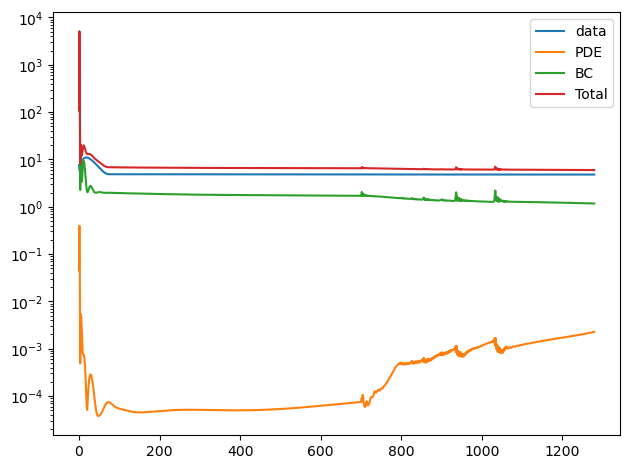

In [163]:
for i in pinn.loss_history.keys():
    if i in loss_weights_init.keys():
        aux_w=loss_weights_init[i]
    else:
        aux_w=1.0
    plt.plot(np.array(pinn.loss_history[i])*aux_w,label=i)
    plt.yscale("log")
plt.legend()
plt.tight_layout()

--- 
## Estimacion de nu 

In [164]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks

In [165]:
class DNN(nn.Module):
    def __init__(self,layers,init_w="xavier",normalize_inputs=False):
        super().__init__() 
        self.layers=layers
        self.normalize_inputs=normalize_inputs
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        if init_w=="xavier":
            #Xavier Normal Initialization
            for i in range(len(layers)-1):
                nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
                
                # set biases to zero
                nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        # convert to float
        a = x.float()
        

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)          
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a


class PINN_nu(DNN):
    '''
        Esta clase hace el registro de todos los parámetros, los cálculos de derivadas y de losses
        Y aplica las restricciones que hagan falta
    '''
    def __init__(self, layers,init_values={"nu":None,"E":None,"alpha":None,"nu_ref":None},train_nu=True,use_of_alpha=True,device=None,separate_data_losses=True,loss_weights_init={"data":1,"PDE":1,"BC":1}):
        super().__init__(layers)
        
        if device is None:
            self.device= "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device=device
        self.to(self.device)


        #History of losses
        self.loss_history = {"data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        
        self.loss_weights_init=loss_weights_init

        self.separate_data_losses=separate_data_losses
        self.params_history ={}
        self.use_of_alpha=use_of_alpha
        self.train_nu=train_nu
        if self.use_of_alpha and self.train_nu:
            #Parameters trials
            self.params_history["nu"]= []
            self.params_history["alpha"]= []

            self.alpha = nn.Parameter(torch.tensor(init_values["alpha"],dtype=torch.float32).to(self.device))
            self.nu_ref = init_values["nu_ref"]
            self.E = torch.tensor((1+self.alpha)*self.nu_ref,dtype=torch.float32).to(self.device)
        elif train_nu:
            self.params_history["nu"]= []

            self.nu = nn.Parameter(torch.tensor(init_values["nu"],dtype=torch.float32).to(self.device))
        else:
            self.nu = torch.tensor(init_values["nu"],dtype=torch.float32).to(self.device)
        #inicialización de parametros
        self.E = init_values["E"]
        self.loss_function = nn.MSELoss(reduction ='mean')


        #podemos tener dos None, y se equilibran entre ellos, y tambien podemos tener los 3, pero no 1 solo none
        claves_none = [key for key, value in self.loss_weights_init.items() if value is None]
        claves_no_none = [key for key, value in self.loss_weights_init.items() if value is not None]
        self.claves_params=None
        assert len(claves_none)+len(claves_no_none)==3,"Algun error con los pesos"
        if len(claves_none) in [2,3]:
            self.claves_params=[f"w_{i}" for i in claves_none[:(len(claves_none)-1)]]
            #entonces las nones se equilibran entre ellas 
            suma_aux=0
            #para todas las que tiene libre variación
            for clave in self.claves_params:
                setattr(self,clave,nn.Parameter(torch.rand(1,dtype=torch.float32).to(self.device)*(1-suma_aux)))
                suma_aux+=getattr(self, clave).item()
                self.params_history[clave] = []

            #esta dependerá de las otras para que todo sume 1
            self.name_w_updatable=f"w_{claves_none[(len(claves_none)-1)]}"    
            setattr(self, self.name_w_updatable, torch.tensor(1 - suma_aux, dtype=torch.float32).to(self.device))
            self.params_history[self.name_w_updatable] = []
        elif len(claves_none)==0 :
            pass
        else:
            raise Exception("no puede variar solo 1 termino, 2 o 3")

        for clave in claves_no_none:
            setattr(self,f"w_{clave}",self.loss_weights_init[clave])


        #esto es para el closure para el optimizador    
        self.iter_n=0

    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone().to(self.device)
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1).to( self.device )
        # Compute the output of the DNN
        U = self(XYZ)
        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)
        return u, v, w

    # Los cálculos de las funciones de pérdida de hacen 1 vez, y luego ya vemos que hacemos
    # con esos datos, si usar pesos, si usar otras cosas...

    def loss_PDE(self, collocation_points, save = True):
        # estos son los puntos en los que imponemos las leyes físicas  
        # puede ser la ecuación de equilibrio, pero también pueden ser otras relaciones
        # que conozcamos entre inputs y outputs, como por ejemplo, relaciones termodinámicas etc..
        # si el output fuera posicion y tensión, entonces podriamos imponer la ley de hooke sobre este
        # input.
        X, Y, Z = self.compute_XYZ(collocation_points)
        u, v, w = self.compute_displacements(X,Y,Z)


        # y ahora tenemos que obtener las derivadas necesarias para aplicar la eq de equilibrio
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon)
        div_sigma = self.divergence(sigma,X, Y, Z)

        value_loss_PDE=self.loss_function(div_sigma,torch.zeros_like(div_sigma).to(self.device))
        
        if save:
            self.loss_history["PDE"].append(value_loss_PDE.item())#.to('cpu').detach().numpy())
        
        return value_loss_PDE
    
    def loss_BC(self,pos_reales,sigmas_reales,save=True):
        #aqui tenemos las de Dirichlet y las de Neumann
        # en mi caso que no hay contacto ni nada, pero si tengo nodos fijos!! las de Dirichlet tbn

        #en esta implementación voy a imponer las sigmas solo aqui, en una futura, podría meter también
        #las de Dirichlet para poder darles mas peso

        #calculamos sobre las posiciones de las sigmas que tenemos, las dadas por el modelo
        # predict U
        X,Y,Z=self.compute_XYZ(pos_reales)
        u, v, w=self.compute_displacements(X,Y,Z)
        
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon) 
        #este sigma tiene primera dimension batchsize, y segunda dimension 6
        #que corresponde con: s11,s22,s33,s23,s13,s12
        #le imponemos que sean iguales de modo que aplicamos la loss y ya
        value_loss_BC=self.loss_function(sigma,sigmas_reales)

        if save:
            self.loss_history["BC"].append(value_loss_BC.item())#.to('cpu').detach().numpy())

        return value_loss_BC


    def loss_data(self, pos_reales,desp_reales,save=True):
        #pos_reales=pos_reales.to(device)
        u_predict=self(pos_reales)
        if self.separate_data_losses:
            sepatared_loss=torch.nn.MSELoss(reduction="none")
            #aux=self.loss_function(u_predict,desp_reales)
            #esto nos devuelve la diferencia cuadrática de cada elemento, para evaluarlos por
            #separado, vamos a hacer la media en columnas
            # x_mse,y_mse,z_mse=torch.mean(aux,axis=0)
            # x_mse,y_mse,z_mse=torch.sqrt(x_mse),torch.sqrt(y_mse),torch.sqrt(z_mse)
            value_loss_data=torch.mean(torch.sqrt(torch.mean(sepatared_loss(u_predict,desp_reales),axis=0)))
        else:
            value_loss_data=self.loss_function(u_predict,desp_reales)

        if save:
            self.loss_history["data"].append(value_loss_data.item())#.to('cpu').detach().numpy())
        
        return value_loss_data
    
    def loss(self, pos_data,desp_data,pos_colloc,pos_BC,sigmas_BC,save=True):
        #esto hace que se calculen todas las losses de la pinn
        #además, si tenemos un parámetro E, este se actualizará, pe si estamos actualizando alpha en lugar
        #de E, despues de la recalculación tendremos que actualizar E. 

        #actualizamos E antes de calcular nada

        if self.use_of_alpha and self.train_nu:
            self.nu=(1+self.alpha)*self.nu_ref

        # #imponemos que se eviten valores de E negativos 
        # self.E = self.E if self.E.item()>0 else self.E * -1

        #los pesos deben ser positivos
        if self.claves_params:
            for clave in self.claves_params:
                setattr(self, clave, torch.clamp(getattr(self,clave),min=0))

            #hay un peso de los weigts que debe de actualizarse si se están actualizando
            if self.name_w_updatable:
                suma_aux=sum([getattr(self,i).item() for i in self.claves_params])
                setattr(self, self.name_w_updatable, torch.tensor(1 - suma_aux, dtype=torch.float32).to(self.device))




        value_loss_PCE=self.loss_PDE(pos_colloc,save=save)
        value_loss_BC=self.loss_BC(pos_BC,sigmas_BC,save=save)
        value_loss_data=self.loss_data(pos_data,desp_data,save=save)  
        value_loss= self.w_data*value_loss_data + self.w_PDE*value_loss_PCE+ self.w_BC*value_loss_BC

        if save: 
            #self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            if self.params_history:
                for key in self.params_history:
                    valor_variable = getattr(self, key).item()#.to('cpu').detach().numpy()
                    self.params_history[key].append(valor_variable)

            self.loss_history["Total"].append(value_loss.item())#.to('cpu').detach().numpy())

        return value_loss

    def compute_gradU(self, X, Y, Z, U, V, W):

        # Compute the gradient of U
        Ux,Uy,Uz = autograd.grad(U, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Uy = autograd.grad(U, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Uz = autograd.grad(U, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx,Vy,Vz = autograd.grad(V, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Vy = autograd.grad(V, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Vz = autograd.grad(V, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of W
        Wx,Wy,Wz = autograd.grad(W, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Wy = autograd.grad(W, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Wz = autograd.grad(W, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_strain(self ,X ,Y ,Z ,u , v, w):
        # Compute strain components using autograd
        nabla_U = self.compute_gradU(X,Y,Z,u, v, w).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))
        return strain


    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(self.device)
        #strain_flat=strain[:,(0,1,2,0,0,1),(0,1,2,1,2,2)] # e00,e11,e22,e01,e02,e12
        self.C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).float().to(self.device)

        return torch.matmul(self.C,strain_flat.T.float()).T.squeeze() #s11,s22,s33,s23,s13,s12

    def divergence(self,sigma, X, Y, Z):
        div_T = torch.zeros(sigma.shape[0],3).to(self.device)
        div_T[:,0]=autograd.grad(sigma[:,0],X,grad_outputs=torch.ones_like(sigma[:,0]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,5],Y,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,4],Z,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,1]=autograd.grad(sigma[:,5],X,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,1],Y,grad_outputs=torch.ones_like(sigma[:,1]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Z,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,2]=autograd.grad(sigma[:,4],X,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Y,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,2],Z,grad_outputs=torch.ones_like(sigma[:,2]).to(self.device),retain_graph=True)[0].squeeze()

        return div_T
    

    def step_closure(self,opt,train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2):
        
        opt.zero_grad()
        
        loss = self.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
        
        loss.backward()
        self.iter_n+=1
        # Print material parameters and loss evolition
        print(f'LBFGS iter: {self.iter_n}, Loss: {loss.item()}')
            
        
        return loss

In [170]:
init_values={"nu":.45,"E":float(E_real_str)}
loss_weights_init={"data":1e1,"PDE":1e2,"BC":1e6}

pinn_nu=PINN_nu(pinn_arch,use_of_alpha=False,train_nu=True,init_values=init_values,loss_weights_init=loss_weights_init)
step_dict = {
    "step_1": {"optim": torch.optim.Adam(pinn_nu.parameters(), lr=1e-2), 
            "epochs": EPOCHS1},
    "step_2": {"optim": torch.optim.Adam(pinn_nu.parameters(), lr=1e-3), 
            "epochs": EPOCHS2},
    "step_3": {"optim": torch.optim.Adam(pinn_nu.parameters(), lr=1e-4), 
            "epochs": EPOCHS3}
}

In [171]:
trainer=Trainer(step_dict)
trainer.train(pinn_nu,data)

step_1
Epoch:  1 loss:  234.94871520996094
Epoch:  2 loss:  25674.2421875
Epoch:  3 loss:  1479.7802734375
Epoch:  4 loss:  20.365055084228516
Epoch:  5 loss:  138.4031219482422
Epoch:  6 loss:  93.91265869140625
Epoch:  7 loss:  31.80828094482422
Epoch:  8 loss:  11.284256935119629
Epoch:  9 loss:  19.6953125
Epoch:  10 loss:  36.290252685546875
Epoch:  11 loss:  48.63302230834961
Epoch:  12 loss:  52.51709747314453
Epoch:  13 loss:  48.862056732177734
Epoch:  14 loss:  40.77104949951172
Epoch:  15 loss:  31.482730865478516
Epoch:  16 loss:  23.349523544311523
Epoch:  17 loss:  17.6120662689209
Epoch:  18 loss:  14.591670989990234
Epoch:  19 loss:  13.99560546875
Epoch:  20 loss:  15.18643856048584
Epoch:  21 loss:  17.385482788085938
Epoch:  22 loss:  19.827789306640625
Epoch:  23 loss:  21.88294219970703
Epoch:  24 loss:  23.137020111083984
Epoch:  25 loss:  23.42284393310547
Epoch:  26 loss:  22.794754028320312
Epoch:  27 loss:  21.46151351928711
Epoch:  28 loss:  19.70270538330078

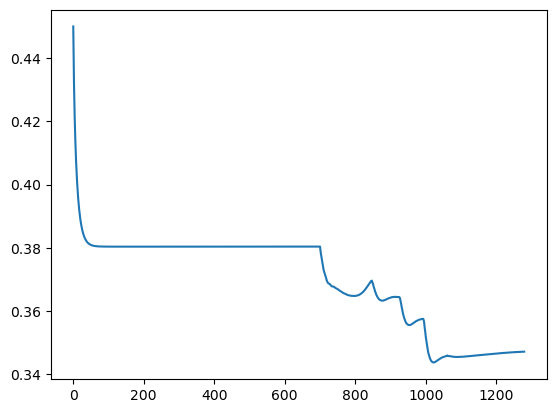

In [173]:
plt.plot(pinn_nu.params_history["nu"])

---  
## Entrenamiento sin data 